In [1]:
import pandas as pd
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import torch

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss

/home/corcasta/miniconda3/envs/farama/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("output.csv")

In [3]:
data

,Age,Male,Female,Quantity,Total_Amount,Product_ID,Product_Category,Price_per_Unit,Time_Unitless,Year,Month,Week,Window_Mean_4,Window_Mean_5,Window_Mean_6,Window_Mean_7
0,19.0,0,1,1,25,0,Beauty,25,0,2023,1,1,81.25,80.0,70.83,78.57
1,19.0,1,0,2,50,0,Beauty,25,1,2023,1,2,81.25,80.0,70.83,78.57
2,34.0,1,2,10,250,0,Beauty,25,2,2023,1,3,81.25,80.0,70.83,78.57
3,0.0,0,0,0,0,0,Beauty,25,3,2023,1,4,81.25,80.0,70.83,78.57
4,23.0,0,1,3,75,0,Beauty,25,4,2023,1,5,93.75,80.0,70.83,78.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,21.0,2,0,6,3000,14,Electronics,500,45,2023,11,47,1625.00,1700.0,1750.00,2142.86
772,0.0,0,0,0,0,14,Electronics,500,46,2023,11,48,1625.00,1300.0,1416.67,1500.00
773,55.0,0,1,3,1500,14,Electronics,500,47,2023,12,49,1125.00,1600.0,1333.33,1428.57
774,50.0,4,1,12,6000,14,Electronics,500,48,2023,12,50,2625.00,2100.0,2333.33,2000.00


In [4]:
data

,Age,Male,Female,Quantity,Total_Amount,Product_ID,Product_Category,Price_per_Unit,Time_Unitless,Year,Month,Week,Window_Mean_4,Window_Mean_5,Window_Mean_6,Window_Mean_7
0,19.0,0,1,1,25,0,Beauty,25,0,2023,1,1,81.25,80.0,70.83,78.57
1,19.0,1,0,2,50,0,Beauty,25,1,2023,1,2,81.25,80.0,70.83,78.57
2,34.0,1,2,10,250,0,Beauty,25,2,2023,1,3,81.25,80.0,70.83,78.57
3,0.0,0,0,0,0,0,Beauty,25,3,2023,1,4,81.25,80.0,70.83,78.57
4,23.0,0,1,3,75,0,Beauty,25,4,2023,1,5,93.75,80.0,70.83,78.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,21.0,2,0,6,3000,14,Electronics,500,45,2023,11,47,1625.00,1700.0,1750.00,2142.86
772,0.0,0,0,0,0,14,Electronics,500,46,2023,11,48,1625.00,1300.0,1416.67,1500.00
773,55.0,0,1,3,1500,14,Electronics,500,47,2023,12,49,1125.00,1600.0,1333.33,1428.57
774,50.0,4,1,12,6000,14,Electronics,500,48,2023,12,50,2625.00,2100.0,2333.33,2000.00


In [5]:
input_features = list(data.columns.drop(["Product_ID", "Total_Amount", "Product_Category", "Time_Unitless"]))
feature_scalers = [None]*len(input_features)
scalers_dict = dict(zip(input_features, feature_scalers))

In [6]:
test_df = data[data["Product_ID"] == 0]

In [7]:
test_df.Total_Amount

0      25
1      50
2     250
3       0
4      75
5      25
6     125
7       0
8     125
9     200
10     25
11      0
12      0
13      0
14      0
15     25
16    375
17    125
18     75
19    100
20     50
21     75
22     25
23      0
24      0
25      0
26    100
27      0
28    100
29    100
30      0
31     50
32      0
33      0
34    250
35     25
36    200
37     50
38      0
39    200
40      0
41    100
42    200
43    250
44      0
45     25
46    100
47    150
48     25
49    175
50     50
51     25
Name: Total_Amount, dtype: int64

In [40]:
max_encoder_length = 8
max_prediction_length = 4

shortest_series_len = data.groupby(["Product_ID"])["Time_Unitless"].max().min()

# This will indicate what will be the training dataset
# And what will be the validation dataset
training_cutoff = shortest_series_len - max_prediction_length


train_dataset = TimeSeriesDataSet(
    data[lambda x: x.Time_Unitless <= training_cutoff],
    time_idx="Time_Unitless",
    target="Total_Amount",
    target_normalizer=None,
    categorical_encoders={"Product_Category": NaNLabelEncoder().fit(data.Product_Category)},
    group_ids=["Product_ID"],
    static_categoricals=[
        "Product_Category"
    ],  # as we plan to forecast correlations, it is important to use series characteristics (e.g. a series identifier)
    time_varying_unknown_reals=["Total_Amount", *input_features],
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    scalers=scalers_dict,
)

valid_dataset = TimeSeriesDataSet.from_dataset(train_dataset, data, min_prediction_idx=training_cutoff + 1)

In [41]:
train_dataset.get_parameters()

{'time_idx': 'Time_Unitless',
 'target': 'Total_Amount',
 'group_ids': ['Product_ID'],
 'weight': None,
 'max_encoder_length': 8,
 'min_encoder_length': 8,
 'min_prediction_idx': 0,
 'min_prediction_length': 4,
 'max_prediction_length': 4,
 'static_categoricals': ['Product_Category'],
 'static_reals': None,
 'time_varying_known_categoricals': None,
 'time_varying_known_reals': None,
 'time_varying_unknown_categoricals': None,
 'time_varying_unknown_reals': ['Total_Amount',
  'Age',
  'Male',
  'Female',
  'Quantity',
  'Price_per_Unit',
  'Year',
  'Month',
  'Week',
  'Window_Mean_4',
  'Window_Mean_5',
  'Window_Mean_6',
  'Window_Mean_7'],
 'variable_groups': None,
 'constant_fill_strategy': None,
 'allow_missing_timesteps': False,
 'lags': None,
 'add_relative_time_idx': False,
 'add_target_scales': False,
 'add_encoder_length': False,
 'target_normalizer': TorchNormalizer(method='identity', center=True, transformation=None, method_kwargs=None),
 'categorical_encoders': {'Product_C

In [42]:
train_dataloader = train_dataset.to_dataloader(batch_size=2)

valid_dataloader = valid_dataset.to_dataloader(batch_size=2)#, batch_sampler="synchronized"


In [11]:
batch_size=4 #, batch_sampler="synchronized"


In [12]:
train_dataset.get_parameters()

{'time_idx': 'Time_Unitless',
 'target': 'Total_Amount',
 'group_ids': ['Product_ID'],
 'weight': None,
 'max_encoder_length': 12,
 'min_encoder_length': 12,
 'min_prediction_idx': 0,
 'min_prediction_length': 8,
 'max_prediction_length': 8,
 'static_categoricals': ['Product_Category'],
 'static_reals': None,
 'time_varying_known_categoricals': None,
 'time_varying_known_reals': None,
 'time_varying_unknown_categoricals': None,
 'time_varying_unknown_reals': ['Total_Amount',
  'Age',
  'Male',
  'Female',
  'Quantity',
  'Price_per_Unit',
  'Year',
  'Month',
  'Week',
  'Window_Mean_4',
  'Window_Mean_5',
  'Window_Mean_6',
  'Window_Mean_7'],
 'variable_groups': None,
 'constant_fill_strategy': None,
 'allow_missing_timesteps': False,
 'lags': None,
 'add_relative_time_idx': False,
 'add_target_scales': False,
 'add_encoder_length': False,
 'target_normalizer': TorchNormalizer(method='identity', center=True, transformation=None, method_kwargs=None),
 'categorical_encoders': {'Product

In [13]:
from pytorch_tcn import TCN
from torch import nn   

In [14]:
def preprocessing_batch(x, y, batch_first=True):
    # *********** THIS HAS TO BE IMPLEMENTED at EVERY iteration during training **************
    # We will extract only the tensor we actually need to feed our model (feature and label tensor)
    x_input = x["encoder_cont"]

    # shape [batchsize, features]
    y_input = torch.squeeze(y[0])

    if batch_first == False:
        # Reshaping to have: shape [Timestep, batchsize, features]
        x_input = x_input.permute([1, 0, 2])

    return x_input, y_input

In [15]:
import time

def train_and_validate(model, loss_criterion, optimizer, epochs, train_data_loader, valid_data_loader, device):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    #writer = SummaryWriter()
    model = model.to(device)
    start = time.time()
    history = []
    best_loss = np.inf   # init to infinity

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):
            inputs, labels = preprocessing_batch(inputs, labels)
            inputs = inputs.to(device).float()
            labels = labels.to(device).float()
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs.float())

            # Compute loss
            loss = loss_criterion(outputs, labels) #.to(torch.float32)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() #* inputs.size(0)

            # Compute the accuracy
            

        
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs, labels = preprocessing_batch(inputs, labels)
                inputs = inputs.to(device).float()
                labels = labels.to(device).float()

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs.cuda().float())

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item()# * inputs.size(0)

        
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/len(train_data_loader) 

        
        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/len(valid_data_loader) 

        
        history.append([avg_train_loss, avg_valid_loss])        
        epoch_end = time.time()
        if avg_valid_loss < best_loss:
            print("New best model saved")
            best_loss = avg_valid_loss
            torch.save(model.state_dict(), 'slippage_model_bw.pt')
            
        print("Epoch : {:03d}, Training: Loss: {:.4f}, \n\t\tValidation : Loss : {:.4f}, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_valid_loss, epoch_end-epoch_start))
  
        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
    #writer.close()      
    return model, history

In [22]:

class TCNPredictor(nn.Module):
    """
    Temporal Convolutional Network for sequence-to-future-value regression
    using pytorch-tcn library.
    Inputs:
      - x: Tensor of shape [batch, seq_len, features] (N, L, C)
    Outputs:
      - out: Tensor of shape [batch, output_size] predicting future values
    """
    def __init__(self,
                 input_size: int = 13,
                 seq_len: int = 12,
                 output_size: int = 8,
                 num_channels: list = [25, 25, 25, 25],
                 kernel_size: int = 4,
                 dropout: float = 0.2):
        super().__init__()
        self.seq_len = seq_len
        # Instantiate TCN for input_shape='NLC'
        self.tcn = TCN(
            num_inputs=input_size,
            num_channels=num_channels,
            kernel_size=kernel_size,
            dropout=dropout,
            input_shape='NLC'
        )
        # Linear layer to map last time-step features to future predictions
        self.flat = nn.Flatten()
        self.linear = nn.Linear(num_channels[-1]*self.seq_len, output_size)
        self.activ = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [batch, seq_len, features]
        # TCN returns: [batch, seq_len, num_channels[-1]] since input_shape='NLC'
        x = self.tcn(x)
        # Take the features at the last time step: [batch, num_channels[-1]]
        print(x.shape)
        print("DEBUG")
        x = self.flat(x)#[:, -1, :]
        # Predict future values
        x = self.linear(x)
        return self.activ(x)

In [23]:
num_epochs = 2
batch_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TCNPredictor(input_size=13, seq_len=max_encoder_length, output_size=8).to(device)

In [24]:
x = torch.randn(4, 12, 13)
y_pred = model(x.to(device))
y_pred

torch.Size([4, 12, 25])
DEBUG


tensor([[0.1227, 0.0000, 0.0000, 0.0000, 0.0000, 0.4869, 0.0000, 0.0000],
        [0.0939, 0.0000, 0.2330, 0.2020, 0.0784, 0.0000, 0.0000, 0.0000],
        [0.1317, 1.0561, 0.0000, 0.3933, 0.6036, 0.0000, 0.0000, 0.0000],
        [0.2625, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<ReluBackward0>)

In [25]:
import torch.optim as optim

# loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [26]:
import numpy as np
trained_model, history = train_and_validate(model, loss_fn, optimizer, num_epochs, train_dataloader, valid_dataloader, device)



Epoch: 1/2
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG
torch.Size([4, 12, 25])
DEBUG

In [27]:
x, y = next(iter(train_dataloader))
output = model(x["encoder_cont"].to(device).float())

torch.Size([4, 12, 25])
DEBUG


In [28]:

pred = output.cpu().detach().numpy()

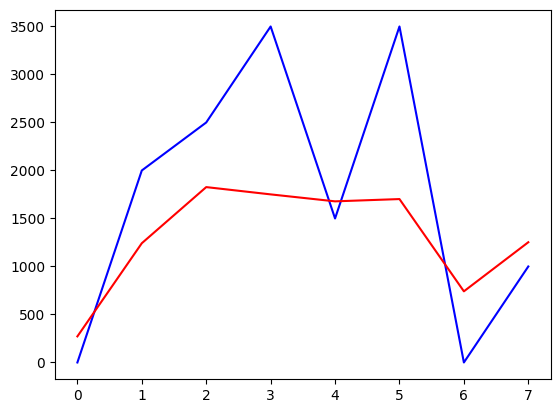

In [155]:
import matplotlib.pyplot as plt
i = 0
plt.plot([i for i in range(y[0].shape[1])], y[0].numpy()[i,:], 'b')
plt.plot([i for i in range(y[0].shape[1])], pred[i,:], 'r')

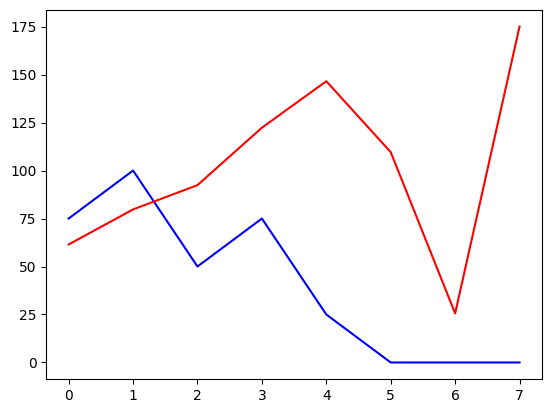

In [156]:
i = 1
plt.plot([i for i in range(y[0].shape[1])], y[0].numpy()[i,:], 'b')
plt.plot([i for i in range(y[0].shape[1])], pred[i,:], 'r')

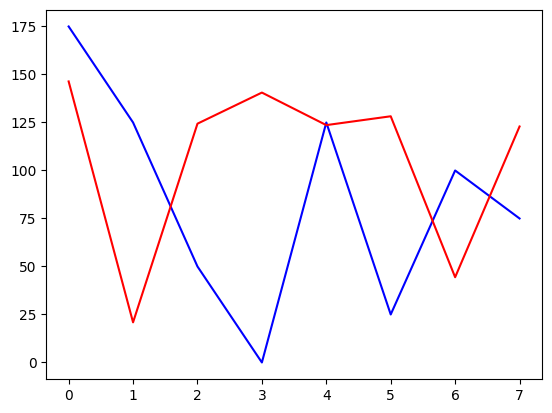

In [157]:
i = 2
plt.plot([i for i in range(y[0].shape[1])], y[0].numpy()[i,:], 'b')
plt.plot([i for i in range(y[0].shape[1])], pred[i,:], 'r')

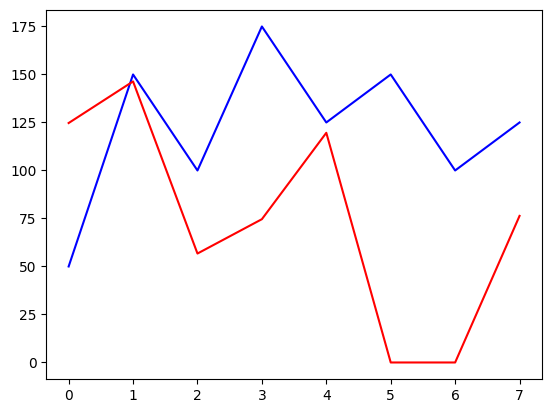

In [158]:
i = 3
plt.plot([i for i in range(y[0].shape[1])], y[0].numpy()[i,:], 'b')
plt.plot([i for i in range(y[0].shape[1])], pred[i,:], 'r')